This is my notebook (https://www.kaggle.com/ahmettahaberberolu) for the kaggle competition https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Right now, my last submission is top 245(Score: 0.12004)

Before starting, this notebook uses a library named EasyMLR: https://github.com/gjpelletier/EasyMLR

# House Prices - Advanced Regression Techniques
**Author**: Ahmet Taha  
**Date**: June 2025  
**Goal**: Predict house sale prices using ensemble learning and hyperparameter tuning.


Necessary Imports

In [144]:
# Basic operations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Modeling and evaluation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OrdinalEncoder

# LightGBM, XGBoost, CatBoost
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

# AutoML and custom models
import optuna

#!pip install git+https://github.com/gjpelletier/EasyMLR.git
from EasyMLR import lgbm, xgb, xgb_auto, gbr_auto


Reading csv and Creating X, y and X_test

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

test_ids = test["Id"]

y = train["SalePrice"]
X = train.drop(["SalePrice", "Id"], axis=1)

X_test = test.drop("Id", axis=1)

Handling Missing Values

In [8]:
def handle_missing_values(df):
    """
    Comprehensive missing value handling for Ames Housing dataset
    """
    # Create a copy to avoid modifying original data
    df_filled = df.copy()
    
    print("Missing values before handling:")
    print(df_filled.isnull().sum().sort_values(ascending=False).head(20))
    print("\n" + "="*50 + "\n")
    
    # 1. CATEGORICAL FEATURES WHERE NA MEANS "NONE" OR "NOT APPLICABLE"
    # These should be filled with meaningful labels
    na_means_none = [
        'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
        'PoolQC', 'Fence', 'MiscFeature'
    ]
    
    for col in na_means_none:
        if col in df_filled.columns:
            df_filled[col] = df_filled[col].fillna('None')
            print(f"Filled {col} NAs with 'None'")
    
    # 2. MASONRY VENEER HANDLING
    # If MasVnrType is None, then MasVnrArea should be 0
    if 'MasVnrType' in df_filled.columns:
        df_filled['MasVnrType'] = df_filled['MasVnrType'].fillna('None')
        print("Filled MasVnrType NAs with 'None'")
    
    if 'MasVnrArea' in df_filled.columns:
        # Fill NAs with 0, especially where MasVnrType is 'None'
        df_filled['MasVnrArea'] = df_filled['MasVnrArea'].fillna(0)
        print("Filled MasVnrArea NAs with 0")
    
    # 3. LOT FRONTAGE - Use sophisticated imputation
    if 'LotFrontage' in df_filled.columns:
        if 'Neighborhood' in df_filled.columns:
            # Fill with median LotFrontage by Neighborhood
            neighborhood_median = df_filled.groupby('Neighborhood')['LotFrontage'].median()
            df_filled['LotFrontage'] = df_filled['LotFrontage'].fillna(
                df_filled['Neighborhood'].map(neighborhood_median)
            )
            # If still NaN, use overall median
            df_filled['LotFrontage'] = df_filled['LotFrontage'].fillna(df_filled['LotFrontage'].median())
            print("Filled LotFrontage NAs with neighborhood median")
        else:
            df_filled['LotFrontage'] = df_filled['LotFrontage'].fillna(df_filled['LotFrontage'].median())
            print("Filled LotFrontage NAs with overall median")
    
    # 4. GARAGE YEAR BUILT
    if 'GarageYrBlt' in df_filled.columns:
        # For houses with garages, use YearBuilt if GarageYrBlt is missing
        if 'YearBuilt' in df_filled.columns:
            mask = (df_filled['GarageYrBlt'].isnull()) & (df_filled['GarageType'] != 'None')
            df_filled.loc[mask, 'GarageYrBlt'] = df_filled.loc[mask, 'YearBuilt']
            print("Filled GarageYrBlt NAs with YearBuilt for existing garages")
        
        # For houses without garages, keep as NaN or fill with 0
        df_filled['GarageYrBlt'] = df_filled['GarageYrBlt'].fillna(0)
        print("Filled remaining GarageYrBlt NAs with 0")
    
    # 5. BASEMENT FEATURES - Numerical
    basement_num_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
    for col in basement_num_cols:
        if col in df_filled.columns:
            df_filled[col] = df_filled[col].fillna(0)
            print(f"Filled {col} NAs with 0")
    
    # 6. GARAGE NUMERICAL FEATURES
    garage_num_cols = ['GarageCars', 'GarageArea']
    for col in garage_num_cols:
        if col in df_filled.columns:
            df_filled[col] = df_filled[col].fillna(0)
            print(f"Filled {col} NAs with 0")
    
    # 7. BASEMENT BATHROOMS
    basement_bath_cols = ['BsmtFullBath', 'BsmtHalfBath']
    for col in basement_bath_cols:
        if col in df_filled.columns:
            df_filled[col] = df_filled[col].fillna(0)
            print(f"Filled {col} NAs with 0")
    
    # 8. CATEGORICAL FEATURES - Use mode imputation
    categorical_mode_fill = [
        'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical',
        'KitchenQual', 'Functional', 'SaleType'
    ]
    
    for col in categorical_mode_fill:
        if col in df_filled.columns and df_filled[col].isnull().sum() > 0:
            mode_value = df_filled[col].mode().iloc[0] if len(df_filled[col].mode()) > 0 else 'Unknown'
            df_filled[col] = df_filled[col].fillna(mode_value)
            print(f"Filled {col} NAs with mode: {mode_value}")
    
    # 9. REMAINING NUMERICAL FEATURES - Use median
    numerical_cols = df_filled.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_filled[col].isnull().sum() > 0:
            median_value = df_filled[col].median()
            df_filled[col] = df_filled[col].fillna(median_value)
            print(f"Filled {col} NAs with median: {median_value}")
    
    # 10. REMAINING CATEGORICAL FEATURES - Use 'Unknown'
    categorical_cols = df_filled.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_filled[col].isnull().sum() > 0:
            df_filled[col] = df_filled[col].fillna('Unknown')
            print(f"Filled {col} NAs with 'Unknown'")
    
    print("\n" + "="*50)
    print("Missing values after handling:")
    remaining_nulls = df_filled.isnull().sum().sum()
    print(f"Total remaining null values: {remaining_nulls}")
    
    if remaining_nulls > 0:
        print("\nColumns still with missing values:")
        print(df_filled.isnull().sum()[df_filled.isnull().sum() > 0])
    else:
        print("✅ All missing values have been handled!")
    
    return df_filled

In [11]:
X_filled = handle_missing_values(X)

Missing values before handling:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageQual        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
KitchenAbvGr       0
dtype: int64


Filled Alley NAs with 'None'
Filled BsmtQual NAs with 'None'
Filled BsmtCond NAs with 'None'
Filled BsmtExposure NAs with 'None'
Filled BsmtFinType1 NAs with 'None'
Filled BsmtFinType2 NAs with 'None'
Filled FireplaceQu NAs with 'None'
Filled GarageType NAs with 'None'
Filled GarageFinish NAs with 'None'
Filled GarageQual NAs with 'None'
Filled GarageCond NAs with 'None'
Filled PoolQC NAs with 'None'
Filled Fence NAs with 'None'
Filled MiscFeature NAs with 'None'
Filled MasVnrType NAs with 'None'
Filled MasVnrArea NAs with 0
Fi

In [14]:
X_test_filled = handle_missing_values(X_test)

Missing values before handling:
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageFinish      78
GarageQual        78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType2      42
BsmtFinType1      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64


Filled Alley NAs with 'None'
Filled BsmtQual NAs with 'None'
Filled BsmtCond NAs with 'None'
Filled BsmtExposure NAs with 'None'
Filled BsmtFinType1 NAs with 'None'
Filled BsmtFinType2 NAs with 'None'
Filled FireplaceQu NAs with 'None'
Filled GarageType NAs with 'None'
Filled GarageFinish NAs with 'None'
Filled GarageQual NAs with 'None'
Filled GarageCond NAs with 'None'
Filled PoolQC NAs with 'None'
Filled Fence NAs with 'None'
Filled MiscFeature NAs with 'None'
Filled MasVnrType NAs with 'None'
Filled MasVnrArea NAs with 0
Fi

Encoding Categorical Features

In [17]:
def encode_categorical_features(df, target_col=None):
    """
    Encode categorical features for XGBoost with proper handling of ordinal vs nominal features
    """
    # Create copies to avoid modifying original data
    df_encoded = df.copy()
    
    print("="*60)
    print("ENCODING CATEGORICAL FEATURES FOR XGBOOST")
    print("="*60)
    
    # Store encoders for later use
    encoders = {}
    
    # 1. ORDINAL FEATURES - These have meaningful order/ranking
    ordinal_features = {
        'OverallQual': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'OverallCond': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
        'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
        'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
        'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
        'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'GrageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
        'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
        'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
        'LandSlope': ['Sev', 'Mod', 'Gtl'],
        'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
        'LandContour': ['Low', 'HLS', 'Bnk', 'Lvl'],
        'PavedDrive': ['N', 'P', 'Y'],
        'Street': ['Grvl', 'Pave'],
        'Alley': ['None', 'Grvl', 'Pave'],
        'CentralAir': ['N', 'Y']
    }
    
    print("Encoding ordinal features:")
    for feature, order in ordinal_features.items():
        if feature in df_encoded.columns:
            # Create ordinal encoder
            encoder = OrdinalEncoder(categories=[order], handle_unknown='use_encoded_value', unknown_value=-1)
            
            # Fit and transform training data
            df_encoded[feature] = encoder.fit_transform(df_encoded[[feature]]).astype(int)
            
            encoders[feature] = encoder
            print(f"  ✓ {feature}: {len(order)} levels")
    
    # 2. NOMINAL FEATURES - No meaningful order, use Label Encoding
    # Get all remaining categorical columns
    categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
    
    # Remove target column if it exists and is specified
    if target_col is not None and target_col in categorical_cols:
        categorical_cols.remove(target_col)
    
    # Remove already processed ordinal features
    nominal_features = [col for col in categorical_cols if col not in ordinal_features.keys()]
    
    print(f"\nEncoding {len(nominal_features)} nominal features:")
    for feature in nominal_features:
        if feature in df_encoded.columns:
            # Create label encoder
            encoder = LabelEncoder()
            
            # Fit and transform training data
            encoder.fit(df_encoded[feature].astype(str))
            df_encoded[feature] = encoder.transform(df_encoded[feature].astype(str))
            
            encoders[feature] = encoder
            print(f"  ✓ {feature}: {len(encoder.classes_)} unique values")
    
    # 3. Handle any remaining object columns
    remaining_object_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
    
    # Remove target column if it exists and is specified
    if target_col is not None and target_col in remaining_object_cols:
        remaining_object_cols.remove(target_col)
    
    if remaining_object_cols:
        print(f"\nHandling remaining object columns: {remaining_object_cols}")
        for col in remaining_object_cols:
            encoder = LabelEncoder()
            df_encoded[col] = encoder.fit_transform(df_encoded[col].astype(str))
            encoders[col] = encoder
    
    print(f"\n✅ Categorical encoding complete!")
    print(f"Total encoders created: {len(encoders)}")
    
    return df_encoded, encoders

In [19]:
X_encoded, encoders = encode_categorical_features(X_filled)

ENCODING CATEGORICAL FEATURES FOR XGBOOST
Encoding ordinal features:
  ✓ OverallQual: 10 levels
  ✓ OverallCond: 10 levels
  ✓ ExterQual: 5 levels
  ✓ ExterCond: 5 levels
  ✓ BsmtQual: 6 levels
  ✓ BsmtCond: 6 levels
  ✓ BsmtExposure: 5 levels
  ✓ BsmtFinType1: 7 levels
  ✓ BsmtFinType2: 7 levels
  ✓ HeatingQC: 5 levels
  ✓ KitchenQual: 5 levels
  ✓ Functional: 8 levels
  ✓ FireplaceQu: 6 levels
  ✓ GarageQual: 6 levels
  ✓ PoolQC: 5 levels
  ✓ Fence: 5 levels
  ✓ LotShape: 4 levels
  ✓ LandSlope: 3 levels
  ✓ Utilities: 4 levels
  ✓ LandContour: 4 levels
  ✓ PavedDrive: 3 levels
  ✓ Street: 2 levels
  ✓ Alley: 3 levels
  ✓ CentralAir: 2 levels

Encoding 21 nominal features:
  ✓ MSZoning: 5 unique values
  ✓ LotConfig: 5 unique values
  ✓ Neighborhood: 25 unique values
  ✓ Condition1: 9 unique values
  ✓ Condition2: 8 unique values
  ✓ BldgType: 5 unique values
  ✓ HouseStyle: 8 unique values
  ✓ RoofStyle: 6 unique values
  ✓ RoofMatl: 8 unique values
  ✓ Exterior1st: 15 unique values

In [21]:
X_test_encoded, encoders_test = encode_categorical_features(X_test_filled)

ENCODING CATEGORICAL FEATURES FOR XGBOOST
Encoding ordinal features:
  ✓ OverallQual: 10 levels
  ✓ OverallCond: 10 levels
  ✓ ExterQual: 5 levels
  ✓ ExterCond: 5 levels
  ✓ BsmtQual: 6 levels
  ✓ BsmtCond: 6 levels
  ✓ BsmtExposure: 5 levels
  ✓ BsmtFinType1: 7 levels
  ✓ BsmtFinType2: 7 levels
  ✓ HeatingQC: 5 levels
  ✓ KitchenQual: 5 levels
  ✓ Functional: 8 levels
  ✓ FireplaceQu: 6 levels
  ✓ GarageQual: 6 levels
  ✓ PoolQC: 5 levels
  ✓ Fence: 5 levels
  ✓ LotShape: 4 levels
  ✓ LandSlope: 3 levels
  ✓ Utilities: 4 levels
  ✓ LandContour: 4 levels
  ✓ PavedDrive: 3 levels
  ✓ Street: 2 levels
  ✓ Alley: 3 levels
  ✓ CentralAir: 2 levels

Encoding 21 nominal features:
  ✓ MSZoning: 5 unique values
  ✓ LotConfig: 5 unique values
  ✓ Neighborhood: 25 unique values
  ✓ Condition1: 9 unique values
  ✓ Condition2: 5 unique values
  ✓ BldgType: 5 unique values
  ✓ HouseStyle: 7 unique values
  ✓ RoofStyle: 6 unique values
  ✓ RoofMatl: 4 unique values
  ✓ Exterior1st: 13 unique values

Taking Log Values of y and scaling our X values to Make Our Models More Accurate

In [24]:
y_log = np.log1p(y)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

ENET

Creating a Hyperparameter Tuner for ENET

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
    score = -np.mean(cross_val_score(model, X_train_scaled, y_log, cv=5, scoring="neg_root_mean_squared_error"))
    
    print(f"Trial {trial.number} finished with alpha={alpha:.5f}, l1_ratio={l1_ratio:.5f}, RMSE={score:.5f}")
    return score

# Create study
study = optuna.create_study(direction="minimize")


# Start optimization
study.optimize(objective, n_trials=200, show_progress_bar=True)

# Show best result
print("\nBest trial so far:")
print(f"  Value (RMSE): {study.best_trial.value:.5f}")
print(f"  Params: {study.best_trial.params}")


Fitting Our Model

In [35]:
enet = ElasticNet(alpha =0.010233281578669061, l1_ratio = 0.31616385047459966)
enet_model = enet.fit(X_train_scaled, y_log)

In [37]:
enet_train_pred = np.expm1(enet_model.predict(X_train_scaled))

Comparing Our Predicted Values With The True Values

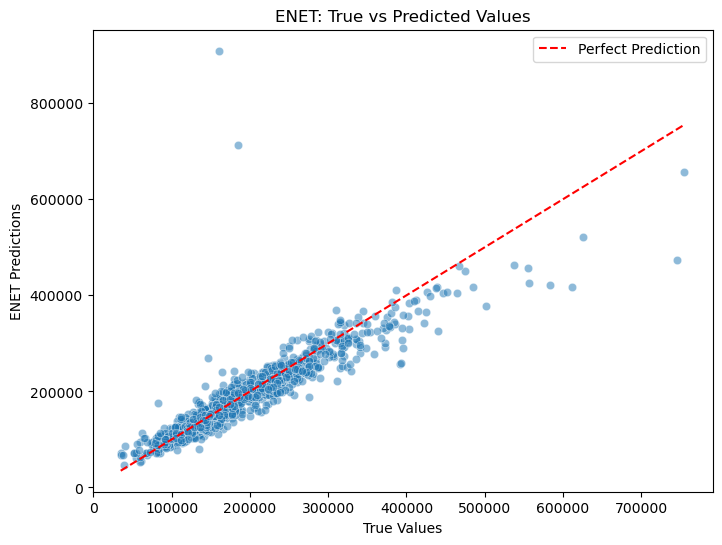

In [40]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=enet_train_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('ENET Predictions')
plt.title('ENET: True vs Predicted Values')
plt.legend()
plt.show()

Making Predictions for The Test Sample

In [43]:
enet_pred = np.expm1(enet_model.predict(X_test_scaled))

Creating a Submission File

In [46]:
res = pd.DataFrame({ 'Id': test_ids, 'SalePrice': enet_pred })
res.to_csv("submissionENETScaled.csv", index=False)

XGBOOST

First XGBoost trial

In [50]:
xgbr = XGBRegressor()
xgb_model = xgbr.fit(X_train_scaled, y_log)

In [52]:
xgb_train_pred = np.expm1(xgb_model.predict(X_train_scaled))

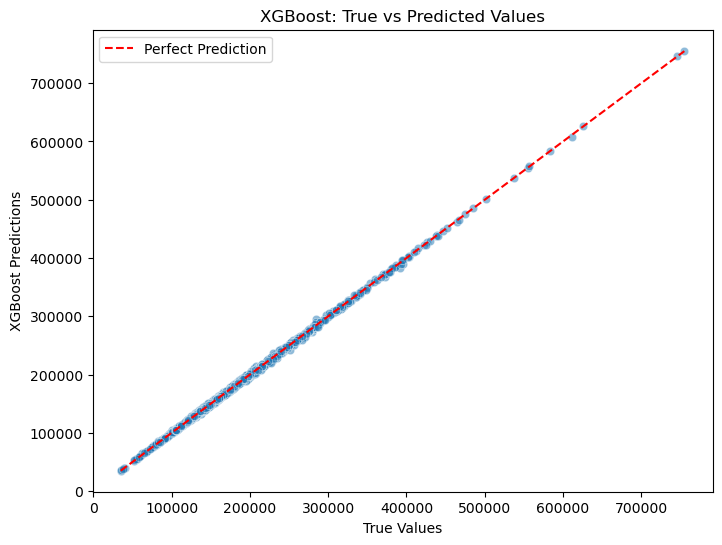

In [54]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=xgb_train_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('XGBoost Predictions')
plt.title('XGBoost: True vs Predicted Values')
plt.legend()
plt.show()

In [56]:
np.sqrt(np.mean((y - xgb_train_pred) ** 2))

1555.8221815023721

Using EasyMLR to Easily Create a Tuned Model

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting XGBRegressor model with best parameters, please wait ...
XGBRegressor statistics of fitted model in model_outputs['stats']:

| Statistic   |   XGBRegressor |
|:------------|---------------:|
| r-squared   |      0.969021  |
| RMSE        |      0.0702824 |
| n_samples   |   1460         |

Done
Time elapsed: 358.29 sec



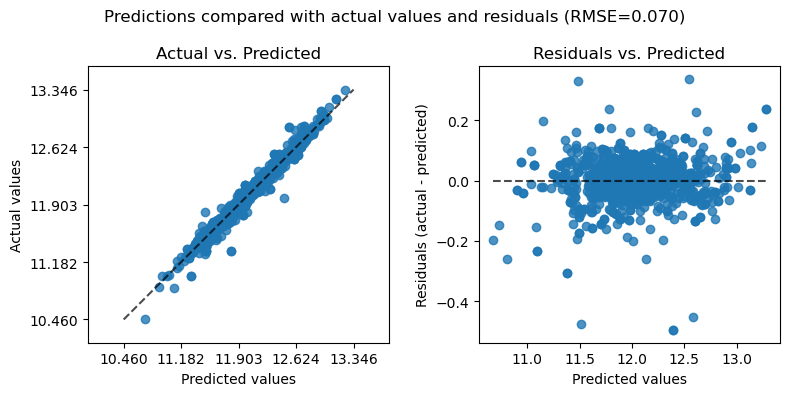

In [61]:
xgb_model31, xgboutput31 = xgb_auto(X_train_scaled, y_log, n_trials=200, random_state=31)

In [64]:
xgb_model31.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5281324711913861,
 'device': 'gpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': 0.0030485586452028146,
 'grow_policy': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.06323136296670316,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 303,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 31,
 'reg_alpha': None,
 'reg_lambda': 6.868990431373921,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': 0.7924705634934448,
 'tree_method': 'auto',
 'validate_parameters'

In [66]:
xgb31_train_pred = np.expm1(xgb_model31.predict(X_train_scaled))

In [68]:
xgb31_pred = np.expm1(xgb_model31.predict(X_test_scaled))

In [70]:
xgb31_pred

array([125637.28, 162216.23, 184642.39, ..., 150083.81, 113891.05,
       210782.11], dtype=float32)

In [72]:
#Creating a Submission File
res = pd.DataFrame({ 'Id': test_ids, 'SalePrice': xgb31_pred })
res.to_csv("submissionXGB31200.csv", index=False)

Creating my own XGB tuner to train more models

In [ ]:

'''
        #used these for higher n_estimators:
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.02, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 3000, 4000),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 3),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.6, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e-3, log=True),
        'nthread': -1,
        'scale_pos_weight': 1,
        'seed': 27,
        'tree_method': 'gpu_hist',
        'verbosity': 0
'''

def objective(trial):
    params = {
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 800, 1200),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.0, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1e-2, log=True),
        'nthread': -1,
        'scale_pos_weight': 1,
        'seed': 27,
        'tree_method': 'gpu_hist',
        'verbosity': 0
    }

    model = XGBRegressor(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_log, scoring='neg_root_mean_squared_error', cv=cv)
    rmse = -np.mean(scores)

    print(f"[Trial {trial.number}] RMSE: {rmse:.4f} | Params: {params}")
    return rmse

def print_best_so_far(study, trial):
    best = study.best_trial
    print(f"→ Best so far [Trial {best.number}] RMSE: {best.value:.4f}")

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200, callbacks=[print_best_so_far])

print("\nFinal best parameters:")
print(study.best_params)


Successful Paramerters I Have Been Able to Find Using My Tuner Function

In [78]:
best_params = {'learning_rate': 0.011152949334328083, 'n_estimators': 3890, 'max_depth': 5, 'min_child_weight': 0, 'gamma': 0.00012197614097065115,
               'subsample': 0.6052243544737391, 'colsample_bytree': 0.6164707864392615, 'reg_alpha': 0.00024088009610848232, 'nthread': -1,
               'scale_pos_weight': 1, 'seed': 27, 'tree_method': 'gpu_hist', 'verbosity': 0}
best_params2 = {'learning_rate': 0.017724647384018955, 'n_estimators': 1070, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.0008338394121098335,
 'subsample': 0.7649596233112123, 'colsample_bytree': 0.7999712626104922, 'reg_alpha': 0.006571693979049847, 'nthread': -1, 'scale_pos_weight': 1,
 'seed': 27, 'tree_method': 'gpu_hist', 'verbosity': 0}

Fiting Our Models(I Used EasyMLR For Quick Graph)

Fitting XGBRegressor model, please wait ...

XGBRegressor statistics of fitted model in model_outputs['stats']:

| Statistic   |   XGBRegressor |
|:------------|---------------:|
| r-squared   |      0.999273  |
| RMSE        |      0.0107661 |
| n_samples   |   1460         |

Done
Time elapsed: 6.44 sec



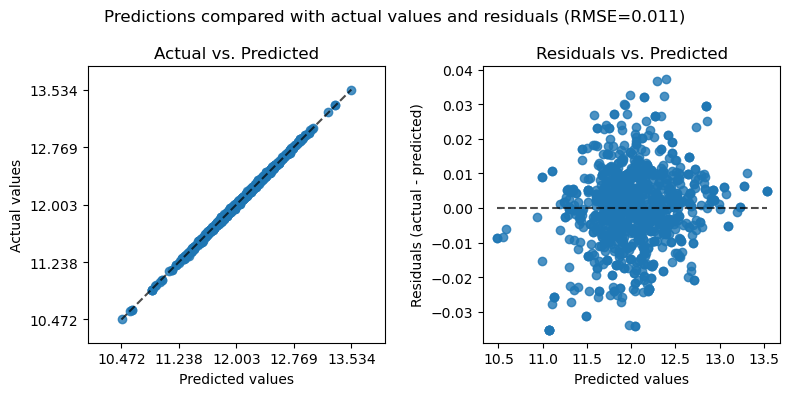

In [81]:
from EasyMLR import xgb
xgb_model51, xgb_output51 = xgb(X_train_scaled, y_log, **best_params)

In [83]:
xgb51_train_pred = np.expm1(xgb_model51.predict(X_train_scaled))

In [85]:
xgb51_pred = np.expm1(xgb_model51.predict(X_test_scaled))
xgb51_pred

array([129339.234, 167781.23 , 183834.84 , ..., 154747.48 , 112081.91 ,
       216228.73 ], dtype=float32)

In [87]:
res = pd.DataFrame({ 'Id': test_ids, 'SalePrice': xgb51_pred })
res.to_csv("submissionXGB51.csv", index=False)

Fitting XGBRegressor model, please wait ...

XGBRegressor statistics of fitted model in model_outputs['stats']:

| Statistic   |   XGBRegressor |
|:------------|---------------:|
| r-squared   |       0.982593 |
| RMSE        |       0.052684 |
| n_samples   |    1460        |

Done
Time elapsed: 1.65 sec



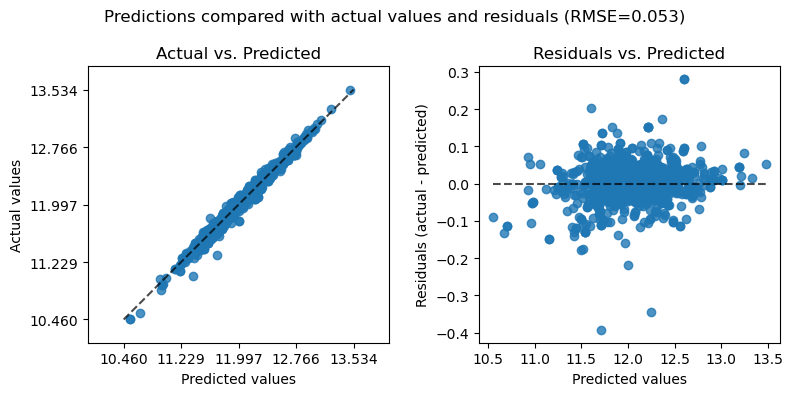

In [89]:
from EasyMLR import xgb
xgb_model52, xgb_output52 = xgb(X_train_scaled, y_log, **best_params2)

In [91]:
xgb52_train_pred = np.expm1(xgb_model52.predict(X_train_scaled))

In [93]:
xgb52_pred = np.expm1(xgb_model52.predict(X_test_scaled))
xgb52_pred

array([125142.81, 163339.08, 182175.45, ..., 157688.6 , 115458.97,
       215803.12], dtype=float32)

In [95]:
res = pd.DataFrame({ 'Id': test_ids, 'SalePrice': xgb52_pred })
res.to_csv("submissionXGB52.csv", index=False)

Catboost

In [98]:
cat_features = [col for col in X_filled.columns if X_filled[col].dtype == "object" or X_filled[col].dtype.name == "category"]
train_pool = Pool(X_filled, y_log, cat_features=cat_features)
test_pool = Pool(X_test_filled, cat_features=cat_features)

In [100]:
cb = CatBoostRegressor()
cb_model = cb.fit(train_pool)

Learning rate set to 0.043466
0:	learn: 0.3880858	total: 124ms	remaining: 2m 4s
1:	learn: 0.3770140	total: 145ms	remaining: 1m 12s
2:	learn: 0.3669697	total: 165ms	remaining: 55s
3:	learn: 0.3571387	total: 186ms	remaining: 46.4s
4:	learn: 0.3474366	total: 214ms	remaining: 42.5s
5:	learn: 0.3384659	total: 234ms	remaining: 38.8s
6:	learn: 0.3305632	total: 256ms	remaining: 36.3s
7:	learn: 0.3216061	total: 277ms	remaining: 34.4s
8:	learn: 0.3132468	total: 299ms	remaining: 32.9s
9:	learn: 0.3054312	total: 319ms	remaining: 31.6s
10:	learn: 0.2976104	total: 342ms	remaining: 30.7s
11:	learn: 0.2901623	total: 366ms	remaining: 30.1s
12:	learn: 0.2833451	total: 388ms	remaining: 29.5s
13:	learn: 0.2766639	total: 413ms	remaining: 29.1s
14:	learn: 0.2710716	total: 436ms	remaining: 28.6s
15:	learn: 0.2654972	total: 460ms	remaining: 28.3s
16:	learn: 0.2595086	total: 483ms	remaining: 28s
17:	learn: 0.2544454	total: 505ms	remaining: 27.6s
18:	learn: 0.2494075	total: 528ms	remaining: 27.3s
19:	learn: 0.2

In [104]:
cb_train_pred = np.expm1(cb_model.predict(train_pool))
cb_train_pred

array([206249.43194421, 177164.44573506, 215650.57925226, ...,
       268242.5017557 , 138582.93126002, 150709.17596944])

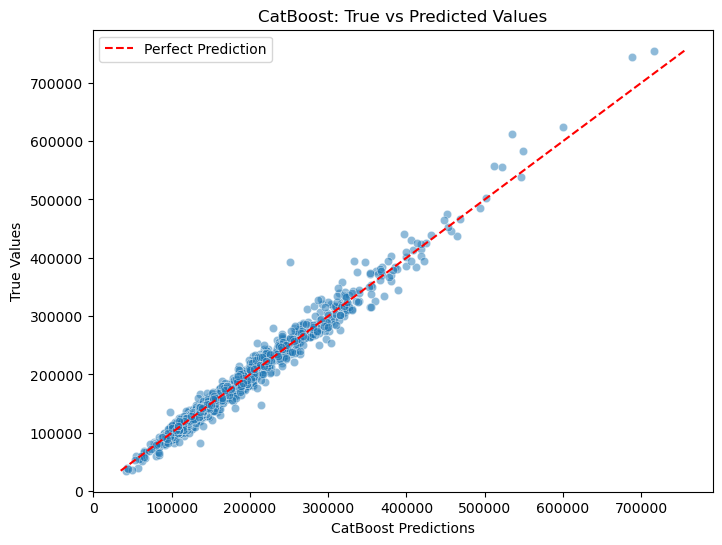

In [106]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=cb_train_pred, y=y, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.ylabel('True Values')
plt.xlabel('CatBoost Predictions')
plt.title('CatBoost: True vs Predicted Values')
plt.legend()
plt.show()

In [108]:
cb_pred = np.expm1(cb_model.predict(test_pool))

In [110]:
cb_pred

array([118633.89474923, 159590.85343289, 189006.69765093, ...,
       162328.85124059, 115694.95560827, 215047.64326751])

In [112]:
res = pd.DataFrame({ 'Id': test_ids, 'SalePrice': cb_pred })
res.to_csv("submissionCB.csv", index=False)

LGBM

Fitting LGBMRegressor model, please wait ...

LGBMRegressor statistics of fitted model in model_outputs['stats']:

| Statistic   |   LGBMRegressor |
|:------------|----------------:|
| r-squared   |       0.987002  |
| RMSE        |       0.0455247 |
| n_samples   |    1460         |

Done
Time elapsed: 0.39 sec



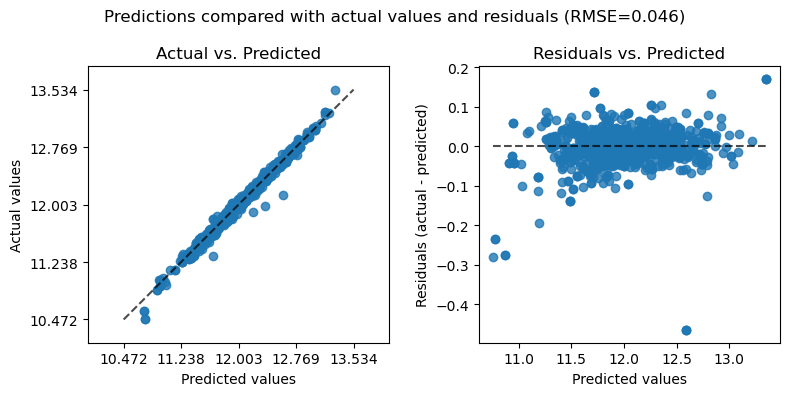

In [115]:
from EasyMLR import lgbm
lgbm_model, lgbm_output = lgbm(X_train_scaled, y_log)

In [117]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1}

My Own Hyperparameter Tuner Here

In [ ]:
import lightgbm as lgb

# Advanced optimization with GPU support and live monitoring
def run_advanced_optimization(X_train_scaled, y_log, n_trials=200):
    """
    Advanced optimization with multiple strategies and GPU support
    """
    
    # Strategy 1: Focus on tree structure
    def objective_tree_focused(trial):
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1,
            'random_state': 42,
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'n_jobs': 1,
            
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'num_leaves': trial.suggest_int('num_leaves', 50, 500),
            
            # Fixed regularization for this strategy
        }
        
        if params['max_depth'] != -1:
            params['num_leaves'] = min(params['num_leaves'], 2 ** params['max_depth'])
        
        try:
            model = lgb.LGBMRegressor(**params)
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_scaled, y_log, 
                                       cv=kf, scoring='neg_root_mean_squared_error', n_jobs=1)
            rmse = -cv_scores.mean()
            print(f"Tree-focused Trial {trial.number}: RMSE = {rmse:.6f} | Params: {params}")
            return rmse
        except Exception as e:
            print(f"Tree-focused Trial {trial.number} failed: {str(e)}")
            return float('inf')
    
    # Run tree-focused optimization
    print("Phase 1: Tree Structure Optimization")
    print("=" * 50)
    study_tree = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study_tree.optimize(objective_tree_focused, n_trials=n_trials//2)
    
    # Strategy 2: Focus on regularization with best tree structure
    best_tree_params = study_tree.best_params
    print(f"\nPhase 1 Complete. Best tree RMSE: {study_tree.best_value:.6f}")
    
    def objective_reg_focused(trial):
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1,
            'random_state': 42,
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'n_jobs': 1,
            
            # Use best tree structure from previous optimization
            'n_estimators': best_tree_params['n_estimators'],
            'learning_rate': best_tree_params['learning_rate'],
            'max_depth': best_tree_params['max_depth'],
            'num_leaves': best_tree_params['num_leaves'],
            
            # Focus on regularization
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1.0, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
            
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        }
        
        try:
            model = lgb.LGBMRegressor(**params)
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_scaled, y_log, 
                                       cv=kf, scoring='neg_root_mean_squared_error', n_jobs=1)
            rmse = -cv_scores.mean()
            print(f"Regularization Trial {trial.number}: RMSE = {rmse:.6f} | Params: {params}")
            return rmse
        except Exception as e:
            print(f"Regularization Trial {trial.number} failed: {str(e)}")
            return float('inf')
    
    # Run regularization-focused optimization
    print("\nPhase 2: Regularization Optimization")
    print("=" * 50)
    study_reg = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study_reg.optimize(objective_reg_focused, n_trials=n_trials//2)
    
    print(f"\nPhase 2 Complete. Best regularization RMSE: {study_reg.best_value:.6f}")
    
    # Return the best study
    if study_tree.best_value < study_reg.best_value:
        print(f"\nBest strategy: Tree Structure (RMSE: {study_tree.best_value:.6f})")
        return study_tree
    else:
        print(f"\nBest strategy: Regularization (RMSE: {study_reg.best_value:.6f})")
        return study_reg

# Usage example for advanced optimization with GPU and live monitoring:

    #For more thorough optimization with detailed monitoring
    print("Starting Advanced GPU-Accelerated Optimization")
    print("=" * 60)
    advanced_study = run_advanced_optimization(X_train_scaled, y_log, n_trials=200)
    print(f"\nAdvanced optimization final best RMSE: {advanced_study.best_value:.6f}")
    print(f"Improvement over baseline: {((0.043 - advanced_study.best_value) / 0.043) * 100:.2f}%")


# Additional utility functions for monitoring
def print_study_statistics(study):
    """Print detailed statistics about the optimization study"""
    print("\n" + "=" * 60)
    print("DETAILED STUDY STATISTICS")
    print("=" * 60)
    
    completed_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
    pruned_trials = [t for t in study.trials if t.state == TrialState.PRUNED]
    failed_trials = [t for t in study.trials if t.state == TrialState.FAIL]
    
    print(f"Total trials: {len(study.trials)}")
    print(f"Completed trials: {len(completed_trials)}")
    print(f"Pruned trials: {len(pruned_trials)}")
    print(f"Failed trials: {len(failed_trials)}")
    
    if completed_trials:
        values = [t.value for t in completed_trials]
        print(f"\nBest RMSE: {min(values):.6f}")
        print(f"Worst RMSE: {max(values):.6f}")
        print(f"Mean RMSE: {np.mean(values):.6f}")
        print(f"Std RMSE: {np.std(values):.6f}")
        
        # Top 5 trials
        print(f"\nTop 5 trials:")
        sorted_trials = sorted(completed_trials, key=lambda t: t.value)[:5]
        for i, trial in enumerate(sorted_trials, 1):
            print(f"  {i}. Trial {trial.number}: RMSE = {trial.value:.6f}")
    
    print("=" * 60)


In [ ]:
advanced_study = run_advanced_optimization(X_train_scaled, y_log, n_trials=200)

Some Parameters I Have Been Able to Find

In [121]:
params = {

          'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1,
            'random_state': 42,
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'n_jobs': 1,
            
            'n_estimators': 1800,
            'learning_rate': 0.005386633988700815,
            'max_depth': 9,
            'num_leaves': 439,
    
            
            'reg_alpha': 0.022133973044475685,
            'reg_lambda': 0.19618205305787914,
            'min_child_samples': 20,
            'min_child_weight': 0.001,
            'min_split_gain': 0.0,
            
            'colsample_bytree': 0.8,
            'subsample': 0.8,
            'subsample_freq': 1,
         
         }

params2 =  {'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse', 'verbosity': -1,
            'random_state': 42,
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'n_jobs': 1,
            
            'n_estimators': 1000,
            'learning_rate': 0.014816456680215405,
            'max_depth': 5,
            'num_leaves': 263,
            
            'reg_alpha': 0.00023841137961699382,
            'reg_lambda': 0.0007742979148971357,
            'min_child_samples': 30,
            'colsample_bytree': 0.3015341106977357,
            'subsample': 0.8780017351073623}

Fitting LGBMRegressor model, please wait ...

LGBMRegressor statistics of fitted model in model_outputs['stats']:

| Statistic   |   LGBMRegressor |
|:------------|----------------:|
| r-squared   |       0.97878   |
| RMSE        |       0.0581676 |
| n_samples   |    1460         |

Done
Time elapsed: 2.10 sec



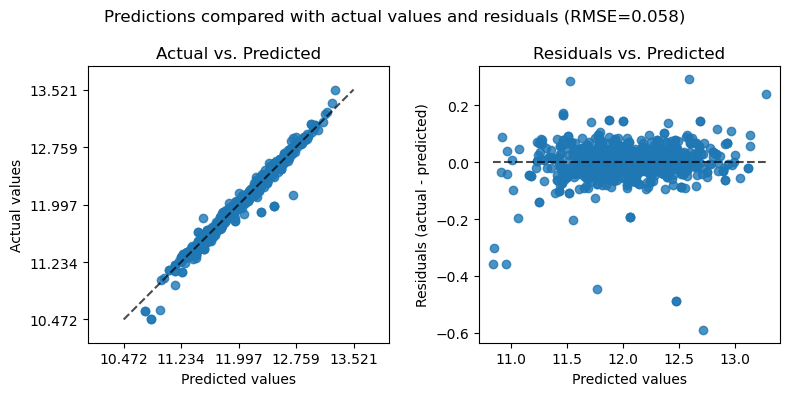

In [123]:
from EasyMLR import lgbm
lgbm_model, lgbm_output = lgbm(X_train_scaled, y_log, **params)

In [125]:
lgbm_train_pred = np.expm1(lgbm_model.predict(X_train_scaled))

C:\Users\Ahmet Taha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [127]:
lgbm_pred = np.expm1(lgbm_model.predict(X_test_scaled))
lgbm_pred

C:\Users\Ahmet Taha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


array([123339.59066988, 157758.83763832, 186932.5220024 , ...,
       155128.88519035, 116025.64912392, 220195.39930384])

In [129]:
res = pd.DataFrame({ 'Id': test_ids, 'SalePrice': lgbm_pred })
res.to_csv("submissionLGBM.csv", index=False)

Fitting LGBMRegressor model, please wait ...

LGBMRegressor statistics of fitted model in model_outputs['stats']:

| Statistic   |   LGBMRegressor |
|:------------|----------------:|
| r-squared   |       0.965306  |
| RMSE        |       0.0743774 |
| n_samples   |    1460         |

Done
Time elapsed: 0.65 sec



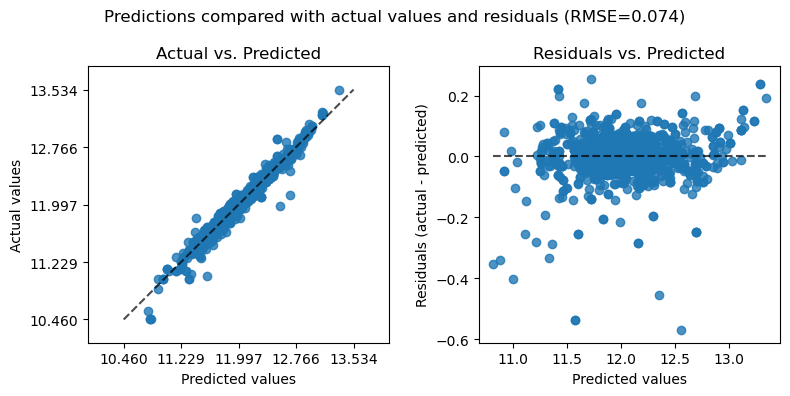

In [131]:
from EasyMLR import lgbm
lgbm_model2, lgbm_output2 = lgbm(X_train_scaled, y_log, **params2)

In [137]:
lgbm2_train_pred = np.expm1(lgbm_model2.predict(X_train_scaled))

C:\Users\Ahmet Taha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [139]:
lgbm2_pred = np.expm1(lgbm_model2.predict(X_test_scaled))
lgbm2_pred

C:\Users\Ahmet Taha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


array([123504.95057027, 160174.4882647 , 183310.66249209, ...,
       163343.87833365, 119848.58880898, 215497.55237406])

In [141]:
res = pd.DataFrame({ 'Id': test_ids, 'SalePrice': lgbm2_pred })
res.to_csv("submissionLGBM_2.csv", index=False)

Stacking Our Best Models for Better Results

In [156]:
meta_model = ElasticNet(alpha=0.001, l1_ratio=0.5)

In [178]:
#I didn't use xgb52 because it reduced results

stack = StackingRegressor(
    estimators=[
        ('enet', enet_model),
        ('xgb31', xgb_model31),
        ('xgb51', xgb_model51),
        ('lgbm1', lgbm_model),
        ('lgbm2', lgbm_model2)
    ],
    final_estimator=meta_model,
    passthrough=True,
    cv=5
)

stack.fit(X_train_scaled, y_log)

C:\Users\Ahmet Taha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:42:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ahmet Taha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:42:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ahmet Taha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:42:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ahmet Taha\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:42:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iterati

,estimators,"[('enet', ...), ('xgb31', ...), ...]"
,final_estimator,ElasticNet(alpha=0.001)
,cv,5
,n_jobs,None
,passthrough,True
,verbose,0
,alpha,0.010233281578669061
,l1_ratio,0.31616385047459966
,fit_intercept,True
,precompute,False
,max_iter,1000


In [188]:
stack_preds = (1.55*np.expm1(stack.predict(X_test_scaled)) + cb_pred)/2.55 
stack_preds

C:\Users\Ahmet Taha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Ahmet Taha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


array([121356.6770847 , 162309.68986529, 183530.18834967, ...,
       158166.79462188, 115598.66392609, 217977.7614369 ])

In [190]:
res = pd.DataFrame({ 'Id': test_ids, 'SalePrice': stack_preds })
res.to_csv("submissionStack.csv", index=False) #rmse 12.004 : top 245